[该篇文章参考了这个](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

# 导入函数库

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim  # 里面主要包含优化器
from torch.optim import lr_scheduler  # 学习率设置
from torchvision import models, transforms, datasets # models里面包含预定义好的模型，如VGG等，transforms主要用于数据转换
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.tensorboard import SummaryWriter  # 用于记录训练日志
import copy

# 设置transform, 用于数据转换

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # 训练集使用的random_crop
        transforms.RandomHorizontalFlip(),  # 随机左右翻转
        transforms.ToTensor(), # convert a PIL image or numpy.ndarray to tensor
        # output[channel] = (input[channel] - mean[channel]) / std[channel]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 对应RGB三通道，前者是mean, 后者是std
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),   # 先resize到256
        transforms.CenterCrop(224),   # 验证集使用的center_crop
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 训练的时候记得把数据和网络都传到GPU上

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # 通过cuda:0指定第一块GPU

# 加载训练集和测试集，并进行batch_size, shuffle等设置

In [4]:
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['train', 'val']}  # 此处的数据集是从文件夹读取的
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}   # 这里的话，训练集和验证集都设置为shuffle=True，一般来说验证集shuffle=False

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# 类别名称

In [5]:
class_names = image_datasets['train'].classes  # 取出来的是一个类别列表

# 图片可视化函数

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))  # pytorch接受的是CHW，所以要先转化成HWC再进行imshow
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean   # 还原像素值
    inp = np.clip(inp, 0, 1)  # 对超过1和小于0的结果进行截断
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 停留一段时间再显示

## 可视化一个batch的训练集图片

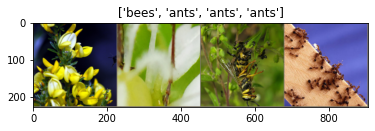

In [7]:
inputs, classes = next(iter(dataloaders['train'])) # inputs的shape=[4, 3, 32, 32], 3指的就是上面说的C

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 封装训练模型函数，其中要注意的点是网络中存在batchnorm，所以在训练的时候model要处于training, 推理的时候model要处于eval

In [8]:
def train_model(model):
    
    model.eval() # 因为此处使用的是resnet，模型中存在dropout等，所以推理的时候要处于eval状态
    
    running_corrects = 0
    
    for inputs, labels in dataloaders['val']:
        # 数据要传送到GPU设备上
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled('val' == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels.data)
            epoch_acc = running_corrects.double() / dataset_sizes['val']
            
            print('{} {:.4f}'.format('val', epoch_acc))
    
    model.train(mode=True)
    return model

# 定义网络结构，此处采用的是训练整个模型，可以看做把预训练过的模型参数拿来当做参数初始化

## 因为预训练的模型是在ImageNet上的，最后一层有1000个神经元，所以要替换最后一层

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

## 加载训练好的模型用于评估

In [10]:
model_ft.load_state_dict(torch.load('resnet18_two_classes.pth'))

<All keys matched successfully>

## 把网络传到GPU上

In [11]:
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 模拟输入，要和预训练模型的输入shape对应上，此处是为了保存模型用于可视化

In [12]:
inputs = torch.ones([1, 3, 224, 224], dtype=torch.float32)

## 声明一个writer实例，用于写入events

In [13]:
writer = SummaryWriter('runs/transfer_learning')

## 把模型写入硬盘

In [14]:
writer.add_graph(model_ft, inputs.to(device))
writer.close()

## 训练模型，设置epoch=25

In [15]:
model_ft = train_model(model_ft)

val 0.0261
val 0.0523
val 0.0784
val 0.1046
val 0.1307
val 0.1569
val 0.1765
val 0.2026
val 0.2288
val 0.2549
val 0.2810
val 0.3072
val 0.3268
val 0.3529
val 0.3725
val 0.3987
val 0.4248
val 0.4510
val 0.4771
val 0.5033
val 0.5294
val 0.5556
val 0.5817
val 0.6078
val 0.6275
val 0.6536
val 0.6797
val 0.6993
val 0.7255
val 0.7516
val 0.7712
val 0.7974
val 0.8235
val 0.8497
val 0.8758
val 0.9020
val 0.9281
val 0.9542
val 0.9608
